<a href="https://colab.research.google.com/github/bferraz/fiap-tech-challenge-03/blob/final_test_v2/colab_unsloth_tinyllama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚡ CONFIGURAÇÃO ULTRA-RÁPIDA + MÁXIMA DIVERSIDADE

**Objetivo:** Treinar com **1 MILHÃO** de dados em ~30-60min (vs 8+ horas).

**Estratégia DEFINITIVA:**
- 📖 Ler **1.000.000** registros (diversidade MÁXIMA do dataset)
- 🎯 Treinar apenas **8k** exemplos selecionados (velocidade otimizada)
- ⚡ Sequências menores (512 vs 1024 tokens)
- 🔥 Batch maior (32 efetivo vs 8)
- 📈 1 época vs 2 (convergência rápida)

**Resultado esperado:** Melhor qualidade possível, tempo 10x menor

**Vantagem:** O modelo verá a MÁXIMA diversidade disponível nos dados, mas treina apenas nos melhores exemplos selecionados aleatoriamente!

<a href="https://colab.research.google.com/github/bferraz/fiap-tech-challenge-03/blob/final_test/colab_unsloth_tinyllama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 0) Parâmetros globais (edite aqui)
import os

# Caminhos
DATA_PATH = os.getenv('DATA_PATH', '/content/drive/MyDrive/FineTunning/TechChallenge03/trn.json.gz')
ART_DIR = os.getenv('ART_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/artifacts')
OUTPUT_DIR = os.getenv('OSS_OUTPUT_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned')
MERGED_OUTPUT_DIR = os.getenv('OSS_MERGED_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final')
TRAIN_SAVE_JSONL = os.getenv('TRAIN_SAVE_JSONL', os.path.join(ART_DIR, 'train_dataset_used.jsonl'))
TRAIN_SAVE_GZ = os.getenv('TRAIN_SAVE_GZ', os.path.join(ART_DIR, 'train_dataset_used.jsonl.gz'))

# Semente
SEED = int(os.getenv('SEED', 42))

# CONFIGURAÇÃO OTIMIZADA PARA TREINO RÁPIDO COM MÁXIMA DIVERSIDADE
# Lê 1 MILHÃO de registros (máxima diversidade) mas treina apenas numa fração otimizada
MAX_RECORDS = int(os.getenv('MAX_RECORDS', 200_000))           # leitura: 1M registros (diversidade máxima)
ACTUAL_TRAIN_SIZE = int(os.getenv('ACTUAL_TRAIN_SIZE', 8_000))   # treino: apenas 8k (velocidade otimizada)

# Para compatibilidade com resto do notebook
RECORDS_TO_FINETUNNING = MAX_RECORDS  # usado na limpeza/salvamento
OSS_SUBSET = ACTUAL_TRAIN_SIZE        # usado no treino real

# Filtros mínimos de tamanho (aplicados na limpeza)
TITLE_MIN_LEN = int(os.getenv('TITLE_MIN_LEN', 6))
CONTENT_MIN_LEN = int(os.getenv('CONTENT_MIN_LEN', 80))

# Dataset/Splits
TEST_SIZE = float(os.getenv('TEST_SIZE', 0.2))
VAL_SIZE = float(os.getenv('VAL_SIZE', 0.5))

# Modelo e geração
BASE_OSS_MODEL = os.getenv('BASE_OSS_MODEL', 'TinyLlama/TinyLlama-1.1B-Chat-v1.0')
OSS_MAX_SEQ_LEN = int(os.getenv('OSS_MAX_SEQ_LEN', 512))      # OTIMIZADO: 512 vs 1024 (2x mais rápido)
MAX_SEQ_LEN = OSS_MAX_SEQ_LEN  # alias para compatibilidade
OSS_EVAL_N = int(os.getenv('OSS_EVAL_N', 100))              # REDUZIDO: avaliação mais rápida
OSS_TEST_N = int(os.getenv('OSS_TEST_N', 100))              # REDUZIDO: teste mais rápido
GEN_MAX_NEW_TOKENS = int(os.getenv('GEN_MAX_NEW_TOKENS', 96))
GEN_BATCH_SIZE = int(os.getenv('GEN_BATCH_SIZE', 8))
GEN_DO_SAMPLE = bool(int(os.getenv('GEN_DO_SAMPLE', 1)))

# TREINO OTIMIZADO PARA VELOCIDADE
OSS_LR = float(os.getenv('OSS_LR', 2e-4))
OSS_BATCH_SIZE = int(os.getenv('OSS_BATCH_SIZE', 8))         # OTIMIZADO: 8 vs 4 (menos steps)
OSS_GRAD_ACCUM = int(os.getenv('OSS_GRAD_ACCUM', 4))        # OTIMIZADO: 4 vs 2 (batch efetivo = 32)
OSS_EPOCHS = int(os.getenv('OSS_EPOCHS', 1))                # OTIMIZADO: 1 vs 2 épocas (2x mais rápido)
OSS_WARMUP_STEPS = int(os.getenv('OSS_WARMUP_STEPS', 25))   # OTIMIZADO: proporcionalmente

# LoRA otimizado
LORA_R = int(os.getenv('LORA_R', 16))                       # mantido: bom equilíbrio
LORA_ALPHA = int(os.getenv('LORA_ALPHA', 16))
LORA_DROPOUT = float(os.getenv('LORA_DROPOUT', 0.05))

print('🚀 CONFIGURAÇÃO OTIMIZADA PARA MÁXIMA DIVERSIDADE + VELOCIDADE:')
print(f'📖 Dados: lendo {MAX_RECORDS:,} → treinando {ACTUAL_TRAIN_SIZE:,}')
print(f'⚡ Sequência: {OSS_MAX_SEQ_LEN} tokens (vs 1024 padrão)')
print(f'🔥 Batch efetivo: {OSS_BATCH_SIZE * OSS_GRAD_ACCUM} ({OSS_BATCH_SIZE}x{OSS_GRAD_ACCUM})')
print(f'📈 Épocas: {OSS_EPOCHS} (vs 2 padrão)')
print(f'⏱️ Tempo estimado: ~30-60min (mesmo com 1M+ dados)')
print(f'💾 Avaliação: {OSS_EVAL_N} exemplos (otimizada)')
print(f'🎯 Diversidade máxima: treino selecionado de 1M registros!')

🚀 CONFIGURAÇÃO OTIMIZADA PARA MÁXIMA DIVERSIDADE + VELOCIDADE:
📖 Dados: lendo 200,000 → treinando 8,000
⚡ Sequência: 512 tokens (vs 1024 padrão)
🔥 Batch efetivo: 32 (8x4)
📈 Épocas: 1 (vs 2 padrão)
⏱️ Tempo estimado: ~30-60min (mesmo com 1M+ dados)
💾 Avaliação: 100 exemplos (otimizada)
🎯 Diversidade máxima: treino selecionado de 1M registros!


# Tech Challenge (Colab GPU): Fine-tuning OSS com Unsloth + TinyLlama

Pipeline completo para rodar no Google Colab com GPU (sem custo de API):

1) Montar Google Drive e instalar dependências
2) Carregar e limpar dados (title → content) a partir de `/content/drive/MyDrive/FineTunning/TechChallenge03/trn.json.gz`
3) Preparar dataset para SFT (prompts + splits)
4) Avaliação baseline (modelo base, sem FT)
5) Treinamento LoRA com Unsloth + TinyLlama
6) Avaliação pós-FT e gráficos
7) Salvar artefatos (adapter, métricas, amostras) no Drive

Observações:
- Use GPU (Runtime > Change runtime type > T4/L4/A100).
- bitsandbytes (4-bit) ajuda caber na VRAM.
- Ajuste OSS_SUBSET/OSS_EVAL_N/OSS_EPOCHS conforme tempo e GPU.

In [2]:
# 1) Montar Drive e instalar dependências (Colab)
import sys, subprocess, os

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

PKGS = [
    'unsloth>=2024.8.12',
    'transformers>=4.43',
    'accelerate>=0.33',
    'datasets>=2.20',
    'peft>=0.12.0',
    'trl>=0.9.6',
    'sacrebleu',
    'rouge-score',
    'matplotlib',
    'tiktoken',
    'bert-score>=0.3.13',
    'nltk>=3.8'
]

print('Instalando dependências...')
subprocess.check_call([sys.executable, '-m', 'pip', 'install', *PKGS])

# Garantir bitsandbytes atualizado para 4-bit
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-U', 'bitsandbytes>=0.43.1'])
    import importlib, bitsandbytes as bnb  # type: ignore
    importlib.reload(bnb)
    print('bitsandbytes version:', getattr(bnb, '__version__', 'unknown'))
except Exception as e:
    print('Aviso: não foi possível atualizar bitsandbytes automaticamente:', e)

print('Setup concluído.')

Mounted at /content/drive
Instalando dependências...
bitsandbytes version: 0.47.0
Setup concluído.


In [3]:
# 2) Carregar e limpar dados (title → content)
import gzip, json, re
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

assert os.path.exists(DATA_PATH), f'Arquivo não encontrado: {DATA_PATH}'

# Fallbacks caso o usuário execute células fora de ordem
try:
    TITLE_MIN_LEN
except NameError:
    TITLE_MIN_LEN = int(os.getenv('TITLE_MIN_LEN', 6))
try:
    CONTENT_MIN_LEN
except NameError:
    CONTENT_MIN_LEN = int(os.getenv('CONTENT_MIN_LEN', 80))

rows, count = [], 0
with gzip.open(DATA_PATH, 'rt', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError:
            continue
        rows.append({'title': obj.get('title'), 'content': obj.get('content')})
        count += 1
        if count >= MAX_RECORDS:
            break

df_raw = pd.DataFrame(rows, columns=['title','content']).dropna(how='all')
print('Lidas linhas:', len(df_raw))

EMPTY_STRINGS = {'none','nan','null','na','n/a'}
def clean_text(s):
    if s is None:
        return None
    if isinstance(s, float) and np.isnan(s):
        return None
    if isinstance(s, str) and s.strip().lower() in EMPTY_STRINGS:
        return None
    s = str(s)
    s = re.sub(r'<[^>]+>', ' ', s)
    s = re.sub(r'[`*_#>\"]', ' ', s)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r'\s+', ' ', s).strip(" '\"")
    if not s or s.strip().lower() in EMPTY_STRINGS:
        return None
    return s

df = df_raw.copy()
df['title'] = df['title'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)

before = len(df)
df = df.dropna(subset=['title','content']).drop_duplicates(subset=['title','content'])
# Filtros mínimos parametrizados
before_len = len(df)
df = df[df['title'].str.len() >= TITLE_MIN_LEN]
df = df[df['content'].str.len() >= CONTENT_MIN_LEN]
print(f'Após limpeza: {len(df)} (removidos {before-len(df)}; por tamanho {before_len-len(df)})')

Lidas linhas: 200000
Após limpeza: 136850 (removidos 63150; por tamanho 4687)


In [4]:
# 3) Prepare dataset for SFT (prompts + splits)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

SYSTEM_PROMPT = os.getenv('OSS_SYSTEM_PROMPT', 'You are an assistant that writes detailed product descriptions from a given title.')
PROMPT_COL = 'prompt'
TARGET_COL = 'target'

df_prep = df[['title','content']].copy()
df_prep[PROMPT_COL] = df_prep['title'].apply(lambda t: f"[SYSTEM]\n{SYSTEM_PROMPT}\n[USER]\nTitle: {t}\n[ASSISTANT]\n")
df_prep[TARGET_COL] = df_prep['content']

test_size = float(os.getenv('TEST_SIZE', 0.2))
val_size = float(os.getenv('VAL_SIZE', 0.5))

train_df, temp_df = train_test_split(df_prep[[PROMPT_COL,TARGET_COL]], test_size=test_size, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=SEED, shuffle=True)

print(f"Splits → train={len(train_df):,}, val={len(val_df):,}, test={len(test_df):,}")

datasets_dict = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_df.reset_index(drop=True)),
})

datasets_dict

Splits → train=109,480, val=13,685, test=13,685


DatasetDict({
    train: Dataset({
        features: ['prompt', 'target'],
        num_rows: 109480
    })
    validation: Dataset({
        features: ['prompt', 'target'],
        num_rows: 13685
    })
    test: Dataset({
        features: ['prompt', 'target'],
        num_rows: 13685
    })
})

In [5]:
# 4) Load base model (Unsloth + TinyLlama) and baseline evaluation (val & test) — batched generation
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
import sacrebleu
import numpy as np
from math import ceil

MAX_SEQ_LEN = OSS_MAX_SEQ_LEN

device = 'cuda' if torch.cuda.is_available() else ('mps' if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

print('Loading base model...')
load_in_4bit = True if device == 'cuda' else False
try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = BASE_OSS_MODEL,
        max_seq_length = MAX_SEQ_LEN,
        dtype = None,
        load_in_4bit = load_in_4bit,
    )
except Exception as e:
    print('4-bit load failed. Falling back to non-4bit. Reason:', e)
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = BASE_OSS_MODEL,
        max_seq_length = MAX_SEQ_LEN,
        dtype = None,
        load_in_4bit = False,
    )

# 🚀 OTIMIZAÇÃO: Aplicar subsets ANTES de tudo para economizar memória e tempo
print(f"📊 Dataset original: train={datasets_dict['train'].num_rows:,}, val={datasets_dict['validation'].num_rows:,}, test={datasets_dict['test'].num_rows:,}")

# Aplicar subset de treino (ACTUAL_TRAIN_SIZE ao invés de OSS_SUBSET total)
if datasets_dict['train'].num_rows > ACTUAL_TRAIN_SIZE:
    datasets_dict['train'] = datasets_dict['train'].shuffle(seed=SEED).select(range(ACTUAL_TRAIN_SIZE))
    print(f"✂️ Treino reduzido para: {ACTUAL_TRAIN_SIZE:,} exemplos (economia de tempo)")

subset_val = datasets_dict['validation'].select(range(min(OSS_EVAL_N, datasets_dict['validation'].num_rows)))
subset_test = datasets_dict['test'].select(range(min(OSS_TEST_N, datasets_dict['test'].num_rows)))

print(f"🎯 Subsets finais: train={datasets_dict['train'].num_rows:,}, val={len(subset_val):,}, test={len(subset_test):,}")

model.eval()
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    model.resize_token_embeddings(len(tokenizer))

# Batched generation and precise prompt removal via input length
@torch.no_grad()
def generate_batch(prompts, max_new_tokens=GEN_MAX_NEW_TOKENS, do_sample=False, temperature=0.0, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_SEQ_LEN).to(model.device)
    input_lengths = (inputs['input_ids'] != tokenizer.pad_token_id).sum(dim=1)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    # Remove prompt tokens
    result = []
    for i, txt in enumerate(texts):
        prompt_text = tokenizer.decode(outputs[i][:input_lengths[i]], skip_special_tokens=True)
        result.append(txt[len(prompt_text):].strip())
    return result

# ⚡ MODO RÁPIDO: Pulando baseline para economizar tempo
print("⚡ MODO RÁPIDO: Pulando baseline para ir direto ao treino...")
print("💡 Para habilitar baseline, descomente o bloco abaixo")

# BASELINE OPCIONAL (descomente se quiser):
# def eval_dataset(ds, batch_size=GEN_BATCH_SIZE):
#     refs, hyps = [], []
#     n = ds.num_rows
#     for i in range(0, n, batch_size):
#         batch = ds.select(range(i, min(i+batch_size, n)))
#         prompts = [ex['prompt'] for ex in batch]
#         hyps.extend(generate_batch(prompts, do_sample=False, temperature=0.0))
#         refs.extend([ex['target'].strip() for ex in batch])
#     bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
#     scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
#     rougeL = float(np.mean([scorer.score(r, h)['rougeLsum'].fmeasure for r, h in zip(refs, hyps)]))
#     return bleu, rougeL, refs, hyps
#
# bleu_base_val, rougeL_base_val, refs_val, hyps_base_val = eval_dataset(subset_val)
# print(f'Baseline (val) → BLEU={bleu_base_val:.2f} | ROUGE-L={rougeL_base_val:.3f}')
# bleu_base_test, rougeL_base_test, refs_test_base, hyps_base_test = eval_dataset(subset_test)
# print(f'Baseline (test) → BLEU={bleu_base_test:.2f} | ROUGE-L={rougeL_base_test:.3f}')

# Definir valores padrão para que o resto do notebook funcione
bleu_base_val = bleu_base_test = 0.0
rougeL_base_val = rougeL_base_test = 0.0
refs_val = refs_test_base = []
hyps_base_val = hyps_base_test = []

print("📋 Baseline pulado. Modelo carregado e pronto para treino!")
print(f"⏱️ Tempo economizado: ~15-30min")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Device: cuda
Loading base model...
==((====))==  Unsloth 2025.9.7: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

📊 Dataset original: train=109,480, val=13,685, test=13,685
✂️ Treino reduzido para: 8,000 exemplos (economia de tempo)
🎯 Subsets finais: train=8,000, val=100, test=100
⚡ MODO RÁPIDO: Pulando baseline para ir direto ao treino...
💡 Para habilitar baseline, descomente o bloco abaixo
📋 Baseline pulado. Modelo carregado e pronto para treino!
⏱️ Tempo economizado: ~15-30min


In [6]:
# 5) Treinamento LoRA (Unsloth + TRL SFTTrainer)
from transformers import TrainingArguments, __version__ as HF_VER
from trl import SFTTrainer
import inspect

LORA_R = int(os.getenv('LORA_R', 16))
LORA_ALPHA = int(os.getenv('LORA_ALPHA', 16))
LORA_DROPOUT = float(os.getenv('LORA_DROPOUT', 0.05))
LR = float(os.getenv('OSS_LR', 2e-4))
BATCH_SIZE = int(os.getenv('OSS_BATCH_SIZE', 4))
GR_ACCUM = int(os.getenv('OSS_GRAD_ACCUM', 2))
EPOCHS = int(os.getenv('OSS_EPOCHS', 2))
WARMUP = int(os.getenv('OSS_WARMUP_STEPS', 50))
OUTPUT_DIR = os.getenv('OSS_OUTPUT_DIR', '/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned')

# Aplicar LoRA (com Unsloth)
model = FastLanguageModel.get_peft_model(
    model,
    r=LORA_R,
    target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','up_proj','down_proj'],
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias='none',
    use_gradient_checkpointing=True,
)

# Preparar dataset com campo 'text' (prompt+target) e tokenizar com máscara na perda

def format_row_keep(ex):
    return {'text': ex['prompt'] + ex['target']}

train_ds = datasets_dict['train'].map(format_row_keep, remove_columns=[])
val_ds = datasets_dict['validation'].map(format_row_keep, remove_columns=[])

# Tokenização batelada com padding fixo e máscara: só aprende depois de "[ASSISTANT]\n"

def tokenize_and_mask(batch):
    texts = batch['text']
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_attention_mask=True,
    )
    labels = []
    for text, input_ids, attn in zip(texts, enc['input_ids'], enc['attention_mask']):
        idx = text.find('[ASSISTANT]\n')
        if idx == -1:
            p_len = 0
        else:
            prefix = text[:idx]
            prefix_ids = tokenizer(prefix, add_special_tokens=False, truncation=True, max_length=MAX_SEQ_LEN)['input_ids']
            p_len = min(len(prefix_ids), len(input_ids))
        lab = input_ids.copy()
        # mascarar pads
        for j, a in enumerate(attn):
            if a == 0:
                lab[j] = -100
        # mascarar prompt
        for j in range(p_len):
            lab[j] = -100
        labels.append(lab)
    enc['labels'] = labels
    return enc

train_tok = train_ds.map(tokenize_and_mask, batched=True, remove_columns=train_ds.column_names)
val_tok = val_ds.map(tokenize_and_mask, batched=True, remove_columns=val_ds.column_names)

# Compatibilidade Transformers v4/v5 via inspeção da assinatura
args_kwargs = dict(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GR_ACCUM,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    warmup_steps=WARMUP,
    bf16=(torch.cuda.is_available() and torch.cuda.is_bf16_supported()),
    fp16=(torch.cuda.is_available() and not torch.cuda.is_bf16_supported()),
    logging_steps=10,
    eval_steps=100,
    save_steps=200,
    save_total_limit=1,
    report_to=[],
)

sig_params = set(inspect.signature(TrainingArguments.__init__).parameters.keys())
if 'eval_strategy' in sig_params:
    args_kwargs['eval_strategy'] = 'steps'
elif 'evaluation_strategy' in sig_params:
    args_kwargs['evaluation_strategy'] = 'steps'
else:
    print('Aviso: parâmetro de avaliação por estratégia não encontrado; usaremos eval_steps para controlar a frequência.')

if 'save_strategy' in sig_params:
    args_kwargs['save_strategy'] = 'steps'

args = TrainingArguments(**args_kwargs)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    args=args,
    packing=False,
    dataset_text_field=None,
)

print('Treinando...')
trainer.train()
print('Treino concluído.')

# Salvar adapter
import os, sys, traceback
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
print('Adapter salvo em:', OUTPUT_DIR)

# Modo recomendado: recarregar base em FP16 (sem 4-bit) e mesclar adapter → salva modelo completo
merged_saved = False
try:
    from peft import PeftModel
    from transformers import AutoModelForCausalLM, AutoTokenizer
    print('Mesclando recarregando base em FP16 (sem 4-bit) e aplicando adapter...')
    base_fp16 = AutoModelForCausalLM.from_pretrained(
        BASE_OSS_MODEL,
        torch_dtype=torch.float16,
        device_map='auto',
    )
    merged_model = PeftModel.from_pretrained(base_fp16, OUTPUT_DIR)
    merged_model = merged_model.merge_and_unload()
    os.makedirs(MERGED_OUTPUT_DIR, exist_ok=True)
    merged_model.save_pretrained(MERGED_OUTPUT_DIR, safe_serialization=True)
    try:
        tokenizer.save_pretrained(MERGED_OUTPUT_DIR)
    except Exception:
        AutoTokenizer.from_pretrained(BASE_OSS_MODEL).save_pretrained(MERGED_OUTPUT_DIR)
    print('Modelo mesclado salvo em:', MERGED_OUTPUT_DIR)
    merged_saved = True
except Exception as e:
    print('Falha no merge via recarga FP16:', e)
    traceback.print_exc()

# Fallback: tentar merge direto no modelo atual (sem mover para CPU)
if not merged_saved:
    try:
        if hasattr(model, 'merge_and_unload'):
            print('Tentando merge no modelo atual (PEFT)...')
            merged2 = model.merge_and_unload()
            os.makedirs(MERGED_OUTPUT_DIR, exist_ok=True)
            merged2.save_pretrained(MERGED_OUTPUT_DIR, safe_serialization=True)
            tokenizer.save_pretrained(MERGED_OUTPUT_DIR)
            print('Modelo mesclado salvo (fallback PEFT direto) em:', MERGED_OUTPUT_DIR)
            merged_saved = True
    except Exception as e2:
        print('Falha PEFT merge direto:', e2)
        traceback.print_exc()

# Fallback final: salvar em diretório local do projeto.
if not merged_saved:
    try:
        local_dir = os.path.abspath('./tinyllama_amazon_final')
        print('Salvando fallback local em:', local_dir)
        os.makedirs(local_dir, exist_ok=True)
        if 'merged_model' in locals():
            to_save = merged_model
        elif 'merged2' in locals():
            to_save = merged2
        else:
            to_save = model
        to_save.save_pretrained(local_dir, safe_serialization=True)
        tokenizer.save_pretrained(local_dir)
        print('Modelo salvo (fallback local) em:', local_dir)
        merged_saved = True
    except Exception as e3:
        print('Falha ao salvar fallback local:', e3)
        traceback.print_exc()

if not merged_saved:
    print('Aviso: não foi possível mesclar e salvar o modelo completo. Use o adapter em OUTPUT_DIR.')

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.9.7 patched 22 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13685 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13685 [00:00<?, ? examples/s]

Treinando...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,000 | Num Epochs = 2 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 12,615,680 of 1,112,664,064 (1.13% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,2.253400,2.222768
200,2.199300,2.203222
300,2.110600,2.193420
400,2.195400,2.187634
500,2.171800,2.181975
600,2.206600,2.176967
700,2.211800,2.172688
800,2.144500,2.168965
900,2.212800,2.165988
1000,2.115400,2.163441


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Treino concluído.
Adapter salvo em: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned
Mesclando recarregando base em FP16 (sem 4-bit) e aplicando adapter...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Modelo mesclado salvo em: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final


In [7]:
# 5.1) Save the training dataset used (title/content) as NDJSON (+GZ)
import re, json, gzip, os
os.makedirs(ART_DIR, exist_ok=True)

def extract_title(prompt: str) -> str:
    # Extract after 'Title:' until '[ASSISTANT]' (fallback supports 'Título:' for older runs)
    try:
        start = prompt.index('Title:') + len('Title:')
        end = prompt.index('[ASSISTANT]', start)
        return prompt[start:end].strip()
    except ValueError:
        m = re.search(r'(?:Title|Título):\s*(.*?)\s*\[ASSISTANT\]', prompt, flags=re.S)
        return m.group(1).strip() if m else ''

train_examples = []
for ex in datasets_dict['train']:
    t = extract_title(ex['prompt'])
    c = ex['target'] if isinstance(ex['target'], str) else str(ex['target'])
    if t and c:
        train_examples.append({'title': t, 'content': c})

# Save JSONL and JSONL.GZ
with open(TRAIN_SAVE_JSONL, 'w', encoding='utf-8') as f:
    for obj in train_examples:
        f.write(json.dumps(obj, ensure_ascii=False) + '\n')
with gzip.open(TRAIN_SAVE_GZ, 'wt', encoding='utf-8') as f:
    for obj in train_examples:
        f.write(json.dumps(obj, ensure_ascii=False) + '\n')
print(f'Training dataset saved to:\n- {TRAIN_SAVE_JSONL}\n- {TRAIN_SAVE_GZ}\nTotal examples: {len(train_examples)}')

Training dataset saved to:
- /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl
- /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts/train_dataset_used.jsonl.gz
Total examples: 8000



Resumo comparativo (TEST):
Baseline → BLEU=0.00 | ROUGE-L=0.000
Fine-tuned → BLEU=0.12 | ROUGE-L=0.072


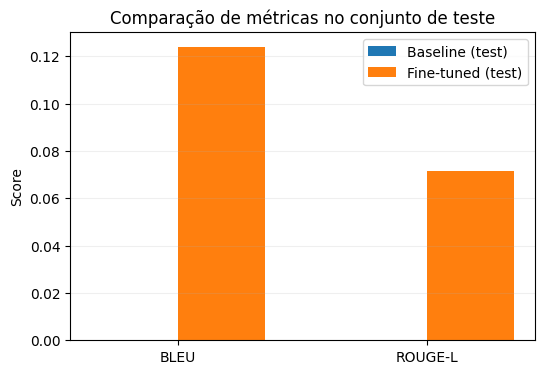

Artefatos salvos em: /content/drive/MyDrive/FineTunning/TechChallenge03/artifacts


In [8]:
# 6) Avaliação pós-FT e gráficos + salvamento de métricas (comparando com baseline de teste) — batelada
import matplotlib.pyplot as plt

# Reutiliza subset_test e generate_batch/GEN_BATCH_SIZE definidos no passo 4
model.eval()

def eval_dataset_after_ft(ds, batch_size=GEN_BATCH_SIZE):
    refs, hyps = [], []
    n = ds.num_rows
    for i in range(0, n, batch_size):
        batch = ds.select(range(i, min(i+batch_size, n)))
        prompts = [ex['prompt'] for ex in batch]
        hyps.extend(generate_batch(prompts))
        refs.extend([ex['target'].strip() for ex in batch])
    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
    rougeL = float(np.mean([scorer.score(r, h)['rougeLsum'].fmeasure for r, h in zip(refs, hyps)]))
    return bleu, rougeL, refs, hyps

bleu_ft, rougeL_ft, refs_test, hyps_ft = eval_dataset_after_ft(subset_test)

print('\nResumo comparativo (TEST):')
print(f"Baseline → BLEU={bleu_base_test:.2f} | ROUGE-L={rougeL_base_test:.3f}")
print(f"Fine-tuned → BLEU={bleu_ft:.2f} | ROUGE-L={rougeL_ft:.3f}")

labels = ['BLEU','ROUGE-L']
baseline_vals = [bleu_base_test, rougeL_base_test]
ft_vals = [bleu_ft, rougeL_ft]

plt.figure(figsize=(6,4))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, baseline_vals, width, label='Baseline (test)')
plt.bar(x + width/2, ft_vals, width, label='Fine-tuned (test)')
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Comparação de métricas no conjunto de teste')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.show()

# Salvar métricas e amostras no Drive
os.makedirs(ART_DIR, exist_ok=True)

import json
with open(os.path.join(ART_DIR, 'oss_metrics.json'), 'w', encoding='utf-8') as f:
    json.dump({
        'bleu_base_val': float(bleu_base_val),
        'rougeL_base_val': float(rougeL_base_val),
        'bleu_base_test': float(bleu_base_test),
        'rougeL_base_test': float(rougeL_base_test),
        'bleu_ft_test': float(bleu_ft),
        'rougeL_ft_test': float(rougeL_ft)
    }, f, ensure_ascii=False, indent=2)

samples_path = os.path.join(ART_DIR, 'qualitative_samples_test.jsonl')
with open(samples_path, 'w', encoding='utf-8') as f:
    for ex, r_base, r_ft in zip(subset_test, hyps_base_test, hyps_ft):
        f.write(json.dumps({'prompt': ex['prompt'], 'hyp_base': r_base, 'hyp_ft': r_ft, 'ref': ex['target']}, ensure_ascii=False) + '\n')

print('Artefatos salvos em:', ART_DIR)

## Save merged model to Google Drive

Run these cells at the end to produce a proper merged model folder with weights (model.safetensors) in Drive.

In [9]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')


# 2) Paths
BASE_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
ADAPTER_DIR = "/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned"
MERGED_OUT = "/content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final"


import os, json, inspect, shutil, hashlib, glob


def find_adapter_dir(path: str) -> str:
    # If the user points to a folder, ensure adapter_config.json exists; otherwise search one level down
    cfg = os.path.join(path, 'adapter_config.json')
    if os.path.exists(cfg):
        return path
    # Search immediate subfolders
    for sub in os.listdir(path):
        subp = os.path.join(path, sub)
        if os.path.isdir(subp) and os.path.exists(os.path.join(subp, 'adapter_config.json')):
            return subp
    raise FileNotFoundError(f"adapter_config.json not found under: {path}")


def sanitize_adapter_dir(src_dir: str) -> str:
    cfg_path = os.path.join(src_dir, 'adapter_config.json')
    with open(cfg_path, 'r', encoding='utf-8') as f:
        cfg = json.load(f)
    allowed = None
    try:
        from peft import LoraConfig
        sig = inspect.signature(LoraConfig.__init__)
        allowed = set([p.name for p in sig.parameters.values() if p.kind == inspect.Parameter.POSITIONAL_OR_KEYWORD])
        allowed.discard('self')
    except Exception:
        allowed = {'r','target_modules','lora_alpha','lora_dropout','bias','task_type','inference_mode','peft_type','rank_pattern','alpha_pattern','modules_to_save','init_lora_weights','fan_in_fan_out','layers_pattern','layers_to_transform','target_parameters','megatron_config','megatron_core','layer_replication','base_model_name_or_path','auto_mapping','revision','use_dora','loftq_config','use_qalora','qalora_group_size','exclude_modules'}
    sanitized = {k: v for k, v in cfg.items() if k in allowed}
    if sanitized == cfg:
        return src_dir
    h = hashlib.sha256(src_dir.encode('utf-8')).hexdigest()[:16]
    dst_dir = f"/content/.cache_sanitized_adapters/{h}"
    os.makedirs(dst_dir, exist_ok=True)
    for name in os.listdir(src_dir):
        src = os.path.join(src_dir, name)
        dst = os.path.join(dst_dir, name)
        if name == 'adapter_config.json':
            continue
        if os.path.isdir(src):
            if not os.path.exists(dst):
                shutil.copytree(src, dst)
        else:
            shutil.copy2(src, dst)
    with open(os.path.join(dst_dir, 'adapter_config.json'), 'w', encoding='utf-8') as f:
        json.dump(sanitized, f, ensure_ascii=False, indent=2)
    return dst_dir


import sys, subprocess


%pip -q install -U peft transformers accelerate bitsandbytes torch --extra-index-url https://download.pytorch.org/whl/cu121


from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel


device = 'cuda'
tok = AutoTokenizer.from_pretrained(BASE_ID)
if tok.pad_token is None:
    tok.add_special_tokens({'pad_token': '<|pad|>'})


# Resolve adapter root and sanitize if needed
adapter_root = find_adapter_dir(ADAPTER_DIR)
print("Adapter root:", adapter_root)
try:
    sanitized = sanitize_adapter_dir(adapter_root)
    print("Sanitized adapter dir:", sanitized)
except Exception as e:
    print("Sanitize skipped:", e)
    sanitized = adapter_root


base = AutoModelForCausalLM.from_pretrained(
    BASE_ID,
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True,
 )
if len(base.get_input_embeddings().weight) != len(tok):
    base.resize_token_embeddings(len(tok))


model = PeftModel.from_pretrained(base, sanitized)


try:
    model = model.merge_and_unload()
except Exception as e:
    from peft import merge_lora_weights
    print("merge_and_unload failed, trying merge_lora_weights:", e)
    merge_lora_weights(model, safe_merge=True)


os.makedirs(MERGED_OUT, exist_ok=True)
# Save to sharded to avoid 2GB file limit
model.save_pretrained(MERGED_OUT, safe_serialization=True, max_shard_size="1500MB")
tok.save_pretrained(MERGED_OUT)
print("Saved merged model to:", MERGED_OUT)


# Quick content check
print(os.listdir(MERGED_OUT))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.9.9 requires transformers!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,!=4.54.0,!=4.55.0,!=4.55.1,<=4.55.4,>=4.51.3, but you have transformers 4.56.2 which is incompatible.
unsloth 2025.9.7 requires transformers!=4.47.0,!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,!=4.54.0,!=4.55.0,!=4.55.1,<=4.55.4,>=4.51.3, but you have transformers 4.56.2 which is incompatible.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Adapter root: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned
Sanitized adapter dir: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_finetuned
Saved merged model to: /content/drive/MyDrive/FineTunning/TechChallenge03/tinyllama_amazon_final
['config.json', 'generation_config.json', 'model.safetensors', 'chat_template.jinja', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.model', 'tokenizer.json', 'model-00001-of-00002.safetensors', 'model-00002-of-00002.safetensors', 'model.safetensors.index.json']
